# Data exploration and pre-processing

## Data reading 

In [1]:
import nltk
import warnings
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [2]:
np.random.seed(27) 
sns.set_style('white')
warnings.filterwarnings('ignore')

The dataset is a csv, where each line is a tweet.


In [3]:
tweets = pd.read_csv("../processed_tweet_data.csv")
tweets[:2]

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,False,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,False,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"


## Pre-processing

All the methods I use to clean and normalize the data are defined in `clean_tweets_dataframe.py` file
so we start by importing that.

In [4]:
sys.path.append(os.path.abspath(os.path.join('..')))
from clean_tweets_dataframe import Clean_Tweets

In [5]:
ct = Clean_Tweets()

### Drop duplicate

First we try to drop duplicates if there are any in the dataset.

In [6]:
print(f"Shape of tweets before droping duplicates tweets {tweets.shape}")
tweets = ct.drop_duplicate(tweets)
print(f"Shape of tweets after droping duplicates tweets {tweets.shape}")


Shape of tweets before droping duplicates tweets (6532, 15)
Shape of tweets after droping duplicates tweets (6532, 15)


this indicates there aren't duplicate values in the data

### Clean original_text

Lets start by removing non english tweets


In [7]:
tweets = ct.remove_non_english_tweets(tweets)

Since we have droped non english tweets, we no longer need lang column.

In [8]:
tweets.drop(['lang'], axis=1, inplace=True)

Remove links

In [9]:
tweets = ct.remove_links(tweets)

Removing Punctuations, Numbers, and Special Characters

In [10]:
tweets = ct.remove_special_characters(tweets)

In [11]:
tweets.original_text[:3]

0     Africa is  in the midst of a full blown third...
1    Dr Moeti is head of WHO in Africa  and one of ...
2    Thank you  research note for creating this ama...
Name: original_text, dtype: object

### Hashtags

There are two types of hashtags in the dataset. 
1) those that are in hashtag column and 
2) those that are inside original-text.

We will clean both and puth theme in separate columns


In [12]:
tweets["hashtags"] = tweets["hashtags"].apply((lambda x: ct.get_element_from_json(x, 'text', '#')))
tweets["hashtags"][:3]

0                 []
1                 []
2    [#red4research]
Name: hashtags, dtype: object

In [13]:
tweets["hashtags"] = tweets["hashtags"].apply(ct.array_to_string)
tweets["hashtags"][:10]

0                              
1                              
2                 #red4research
3                              
4                              
5    #WeCanDoThis, #WeCanDoThis
6                              
7                              
8                              
9                      #Covid19
Name: hashtags, dtype: object

Hashtags in original_text

In [14]:
new_df = pd.DataFrame(columns=['hashtags'])
new_df['hashtags'] = tweets.original_text.apply(ct.find_hashtags)
new_df[:5]

,hashtags
0,[]
1,[]
2,[#red]
3,[#Covid]
4,[]


In [15]:
tweets["hashtags_in_tweets"] = new_df["hashtags"].apply(ct.array_to_string)
tweets["hashtags_in_tweets"][:10]

0                         
1                         
2                     #red
3                   #Covid
4                         
5     #WeCanDoThis, #COVID
6                         
7                         
8                         
9    #Covid, #DeltaVariant
Name: hashtags_in_tweets, dtype: object

### Screan Names

Screan names are usernames that are mentiond in original_text

In [16]:
tweets["screen_name"] = tweets["user_mentions"].apply(
    (lambda x: ct.get_element_from_json(x, 'screen_name', "@",)))
tweets["screen_name"][:3]

0       [@TelGlobalHealth, @TelGlobalHealth]
1                          [@globalhlthtwit]
2    [@NHSRDForum, @NHSRDForum, @NHSRDForum]
Name: screen_name, dtype: object

In [17]:
tweets["screen_name"] = tweets["screen_name"].apply(ct.array_to_string)
tweets["screen_name"][:3]


0       @TelGlobalHealth, @TelGlobalHealth
1                          @globalhlthtwit
2    @NHSRDForum, @NHSRDForum, @NHSRDForum
Name: screen_name, dtype: object

Now we have extracted screen_name from user_mentions, we can drop the collumn.

In [18]:
tweets.drop(['user_mentions'], axis=1, inplace=True)

### Device

Screan names are usernames that are mentiond in original_text

In [19]:
tweets["device"] = tweets["source"].apply(ct.get_device_name)
tweets["device"][:3]

0    Twitter for iPhone
1       Twitter Web App
2    Twitter for iPhone
Name: device, dtype: object

Now we have extracted the device name, we dont need source.

In [20]:
tweets.drop(['source'], axis=1, inplace=True)

### Turn all the text to lowercase


In [21]:
tweets = ct.to_lower(tweets)

### Missing values

In [22]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   original_text       6532 non-null   object 
 2   polarity            6532 non-null   float64
 3   subjectivity        6532 non-null   float64
 4   favorite_count      6532 non-null   int64  
 5   retweet_count       6532 non-null   int64  
 6   original_author     6532 non-null   object 
 7   followers_count     6532 non-null   int64  
 8   friends_count       6532 non-null   int64  
 9   possibly_sensitive  3618 non-null   object 
 10  hashtags            6532 non-null   object 
 11  place               4088 non-null   object 
 12  hashtags_in_tweets  6532 non-null   object 
 13  screen_name         6532 non-null   object 
 14  device              6532 non-null   object 
dtypes: float64(2), int64(4), object(9)
memory usage: 1.0+ M

In [23]:
print("The number of missing value(s): {}".format(tweets.isnull().sum().sum()))
print("Columons having columns value: {}".format( tweets.columns[tweets.isnull().any()]))

The number of missing value(s): 5358
Columons having columns value: Index(['possibly_sensitive', 'place'], dtype='object')


In [24]:
tweets["possibly_sensitive"].fillna(False, inplace=True) # assume its not sensative
tweets["place"].fillna(" ", inplace=True)

### Convert all the columns to correct data type

In [25]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          6532 non-null   object 
 1   original_text       6532 non-null   object 
 2   polarity            6532 non-null   float64
 3   subjectivity        6532 non-null   float64
 4   favorite_count      6532 non-null   int64  
 5   retweet_count       6532 non-null   int64  
 6   original_author     6532 non-null   object 
 7   followers_count     6532 non-null   int64  
 8   friends_count       6532 non-null   int64  
 9   possibly_sensitive  6532 non-null   bool   
 10  hashtags            6532 non-null   object 
 11  place               6532 non-null   object 
 12  hashtags_in_tweets  6532 non-null   object 
 13  screen_name         6532 non-null   object 
 14  device              6532 non-null   object 
dtypes: bool(1), float64(2), int64(4), object(8)
memory usag

#### convert text columns to string

We choose `StringDtype` over `object` for this reasons:
- You can accidentally store a mixture of strings and non-strings in an object dtype array. It’s better to have a dedicated dtype.
- object dtype breaks dtype-specific operations like DataFrame.select_dtypes(). There isn’t a clear way to select just text while excluding non-text but still object-dtype columns.
- When reading code, the contents of an object dtype array is less clear than 'string'.

In [26]:
tweets = ct.convert_to_string(tweets)

Convert time to datetime

In [27]:
print(f"The first row created time before conversion {tweets.created_at[0]}")
tweets = ct.convert_to_datetime(tweets)
print(f"The first row created time after conversion {tweets.created_at[0]}")

The first row created time before conversion Fri Jun 18 17:55:49 +0000 2021
The first row created time after conversion 2021-06-18 17:55:49+00:00


Convert numeric values to number

In [28]:
tweets = ct.convert_to_numbers(tweets)

Convert possible_sansitive column to boolean

In [29]:
tweets = ct.convert_to_boolean(tweets)

Convert possible_sansitive column to boolean

In [30]:
tweets = ct.convert_to_numbers(tweets)

In [31]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6532 entries, 0 to 6531
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   created_at          6532 non-null   datetime64[ns, UTC]
 1   original_text       6532 non-null   string             
 2   polarity            6532 non-null   float64            
 3   subjectivity        6532 non-null   float64            
 4   favorite_count      6532 non-null   int64              
 5   retweet_count       6532 non-null   int64              
 6   original_author     6532 non-null   string             
 7   followers_count     6532 non-null   int64              
 8   friends_count       6532 non-null   int64              
 9   possibly_sensitive  6532 non-null   bool               
 10  hashtags            6532 non-null   string             
 11  place               6532 non-null   string             
 12  hashtags_in_tweets  6532 non-null 

### Finaly we will save cleaned data

In [32]:
tweets.to_csv(r'clean_tweets.csv', index=False, header=True)

## Data exploration 

### Rows and columns in the dataset

In [33]:
tweets = pd.read_csv("clean_tweets.csv")

In [34]:
print('Count of columns in the data is:  ', len(tweets.columns))
print('Count of rows in the data is:  ', len(tweets))

Count of columns in the data is:   15
Count of rows in the data is:   6532


### Users that made the tweets

In [35]:
tweets.groupby("original_author").size().agg( ['count', 'min', 'max', 'mean', 'median'])

count     5248.000000
min          1.000000
max        530.000000
mean         1.244665
median       1.000000
dtype: float64

From this we can observe the tweets were made by 5248 users. Most of them had made one tweet and 
one person had made 530 tweets.

In [36]:
twetter_users = tweets.groupby("original_author").size()
twetter_users.nlargest(5)

original_author
puneupdater        530
viralvideovlogs     45
signal__pump        27
who__india          27
rosenchild          11
dtype: int64

This indicates the person who made 530 tweets is an outlier. Maybe we can drop this columns because we don't want one person's opinion to influence our model.

### Devices from wich tweets are made

In [37]:
tweets.groupby("device").size().agg( ['count', 'min', 'max', 'mean', 'median'])

count       98.000000
min          1.000000
max       2071.000000
mean        66.653061
median       1.000000
dtype: float64

In [38]:
twetter_device = tweets.groupby("device").size()
twetter_device.nlargest(5)


device
twitter for android    2071
twitter for iphone     1982
twitter web app        1345
vaccine finder          530
twitter for ipad        267
dtype: int64

Most tweets were from mobile device. 

### Tweet sentiments

In [39]:
def text_category(p):
  if p > 0:
    return "positive"
  elif p < 0:
    return "negative"
  else:
    return "neutral" 

In [40]:
tweets["score"] = tweets["polarity"].apply(text_category)
tweets.groupby("score")["polarity"].count()


score
negative    1277
neutral     1829
positive    3426
Name: polarity, dtype: int64

In [41]:
tweet_sent = tweets.groupby(['score']).sum()[["retweet_count", "favorite_count", "followers_count", "friends_count"]]
tweet_sent

,retweet_count,favorite_count,followers_count,friends_count
score,,,,
negative,88602,159704,10157572,1278012
neutral,326311,396722,36775025,2520950
positive,414183,1030171,60839857,7355421


We can observe positive tweets are more retweeted, liked and people with more followers and friends had made a positive tweet about covid 19.

### Hashtags

In [69]:
tweets_df = pd.DataFrame(columns=['hashtags', 'hashtags_in_tweets'])
tweets_df['hashtags'] = tweets['hashtags'].apply(ct.string_to_array)
tweets_df['hashtags_in_tweets'] = tweets['hashtags_in_tweets'].apply(
    ct.string_to_array)
tweets_df[:4]

,hashtags,hashtags_in_tweets
0,None,None
1,None,None
2,[#red4research],[#red]
3,None,[#covid]


In [70]:
tweets_df.dropna(inplace=True)
tweets_df[:4]

,hashtags,hashtags_in_tweets
2,[#red4research],[#red]
5,"[#wecandothis, #wecandothis]","[#wecandothis, #covid]"
9,[#covid19],"[#covid, #deltavariant]"
10,"[#wecandothis, #wecandothis]","[#wecandothis, #covid]"


In [44]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in tweets_df.hashtags
     for hashtag in hashtags_list],
    columns=['hashtag'])
flattened_hashtags_df[:4]

,hashtag
0,#red4research
1,#wecandothis
2,#wecandothis
3,#covid19


In [45]:
flattened_hashtags_df.value_counts()[:10]

hashtag      
#covid19         2081
#wecandothis      287
#coronavirus      122
#deltavariant      91
#uganda            88
#africa            82
#cuban             78
#china             55
#tanzania          54
#bihar             44
dtype: int64

In [46]:
flattened_hashtags_in_tweets_df = pd.DataFrame(
    [hashtag for hashtags_list in tweets_df.hashtags_in_tweets
     for hashtag in hashtags_list],
    columns=['hashtag'])

flattened_hashtags_in_tweets_df[:4]

,hashtag
0,#red
1,#wecandothis
2,#covid
3,#covid


In [47]:
flattened_hashtags_in_tweets_df.value_counts()[:10]

hashtag          
#covid               2464
#vaccines             210
#africa               176
#coronavirus          158
#wecandothis          151
#deltavariant         121
#covidvaccination      71
#vaccine               68
#astrazeneca           52
#uganda                52
dtype: int64

### screen_names

In [48]:
tweets_df = pd.DataFrame(columns=['screen_name', ])
tweets_df['screen_name'] = tweets['screen_name'].apply(ct.string_to_array)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   screen_name  5113 non-null   object
dtypes: object(1)
memory usage: 51.2+ KB


In [49]:
tweets_df.dropna(inplace=True)
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5113 entries, 0 to 6531
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   screen_name  5113 non-null   object
dtypes: object(1)
memory usage: 79.9+ KB


In [50]:
flattened_screen_name_df = pd.DataFrame(
    [hashtag for screen_name_list in tweets_df.screen_name
     for hashtag in screen_name_list],
    columns=['hashtag'])
flattened_screen_name_df[:4]

,hashtag
0,@telglobalhealth
1,@telglobalhealth
2,@globalhlthtwit
3,@nhsrdforum


In [51]:
flattened_screen_name_df.value_counts()[:10]

hashtag         
@shawajason         715
@telglobalhealth    368
@cdcgov             237
@globalhlthtwit     206
@bogochisaac        194
@cdcdirector        143
@winnie_byanyima    121
@itranslate123      112
@moetitshidi         99
@drericding          95
dtype: int64

## Visualisations

### Users that made the tweets


<AxesSubplot:title={'center':'original_author'}, xlabel='original_author'>

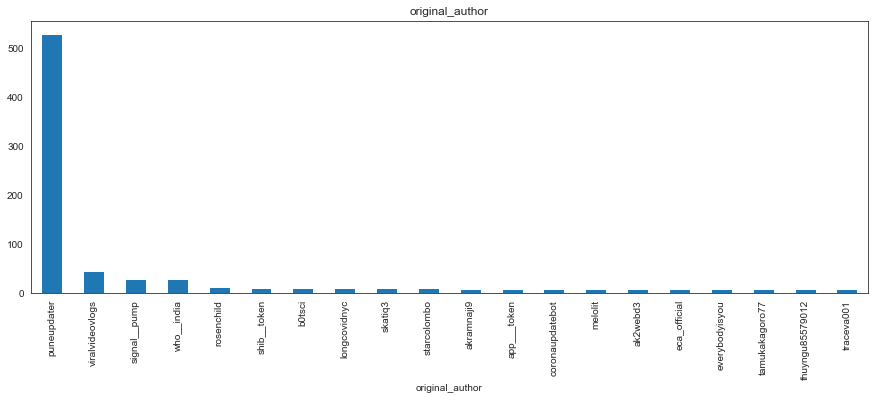

In [52]:
twetter_users.nlargest(20).plot(
    kind='bar', title='original_author', figsize=(15, 5))


This indicates most tweets are made by unique individuals.

### device

<AxesSubplot:title={'center':'device'}, xlabel='device'>

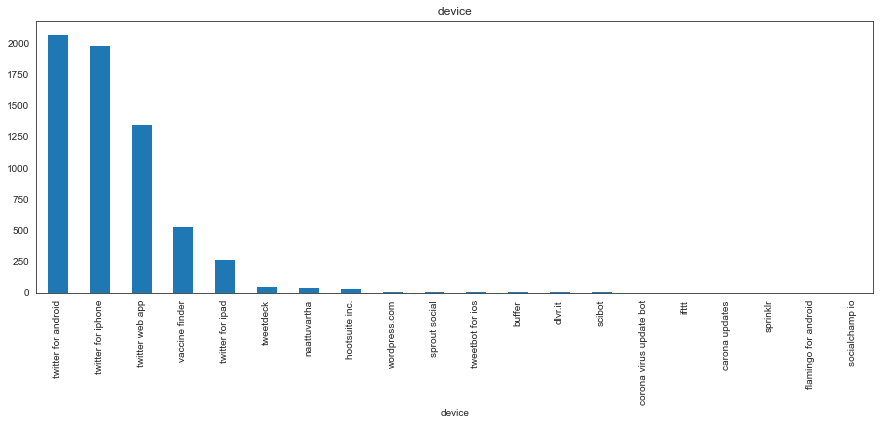

In [53]:
twetter_device.nlargest(20).plot(
    kind='bar', title='device', figsize=(15, 5))

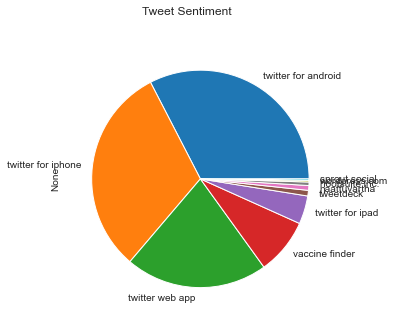

In [54]:
ax = twetter_device.nlargest(10).plot(
    kind='pie', title='Tweet Sentiment', subplots=True, figsize=(15, 5))

### Tweet sentiments

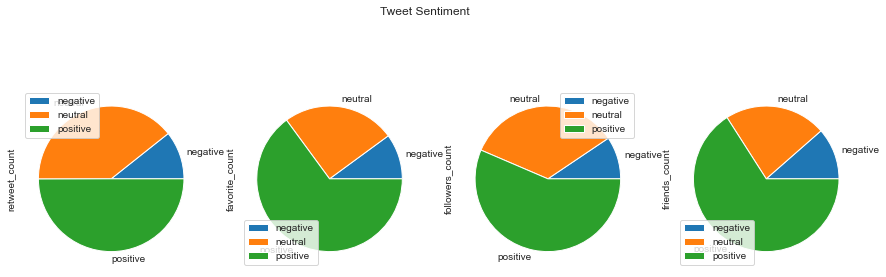

In [55]:
ax = tweet_sent.plot(
    kind='pie', title='Tweet Sentiment', subplots=True, figsize=(15, 5))


### Hashtags

<AxesSubplot:title={'center':'Hashtags'}, xlabel='hashtag'>

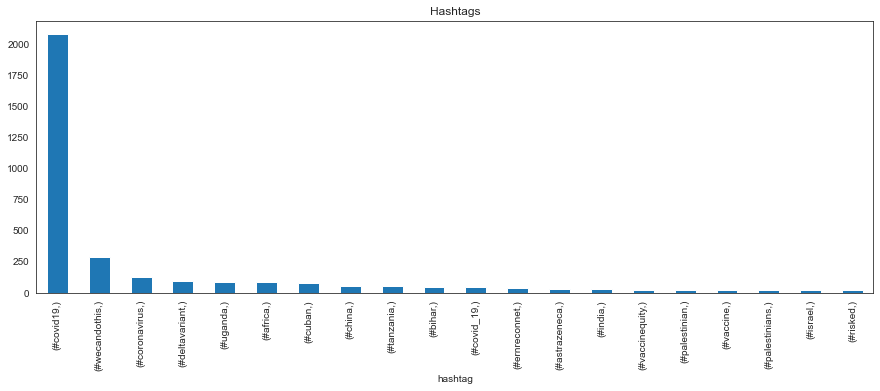

In [56]:
flattened_hashtags_df.value_counts()[:20].plot(
    kind='bar', title='Hashtags', figsize=(15, 5))

<AxesSubplot:title={'center':'Hashtags in tweet'}, xlabel='hashtag'>

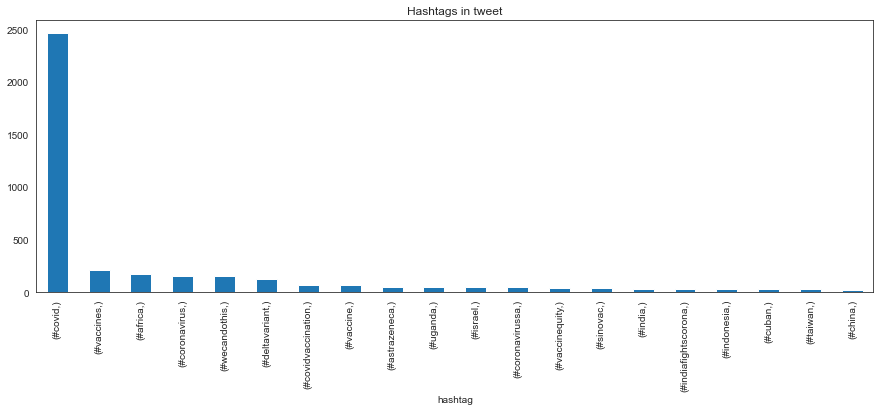

In [57]:
flattened_hashtags_in_tweets_df.value_counts()[:20].plot(
    kind='bar', title='Hashtags in tweet', figsize=(15, 5))


### screen_names

<AxesSubplot:title={'center':'Screan Names'}, xlabel='hashtag'>

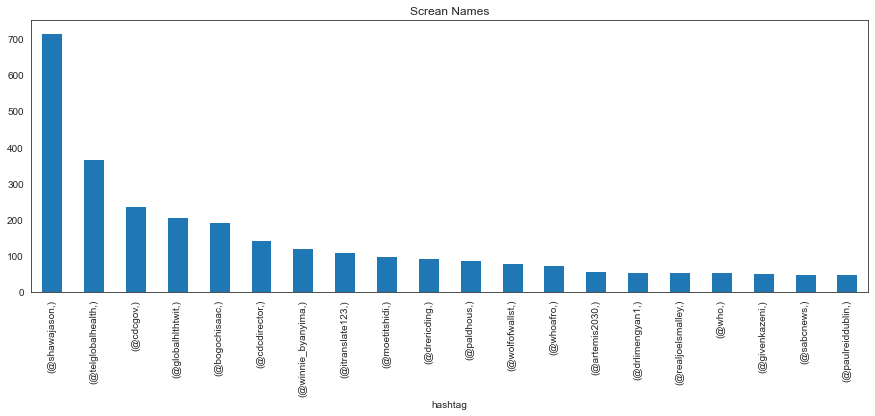

In [58]:
flattened_screen_name_df.value_counts()[:20].plot(
    kind='bar', title='Screan Names', figsize=(15, 5))

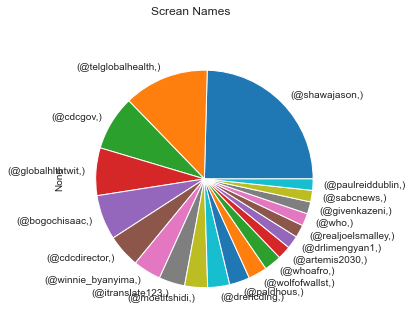

In [59]:
ax = flattened_screen_name_df.value_counts()[:20].plot(
    kind='pie', title='Screan Names', subplots=True, figsize=(15, 5))


### words cloud for positive tweets

In [60]:
tweets['clean_text'] = tweets['original_text'].astype(str)
tweets['clean_text'] = tweets['clean_text'].apply( lambda x: x.lower())
positive_tweets = tweets[tweets['score'] == 'positive']

In [61]:
custom_stopwords = ['t', 'rt', 'ti', 'vk', 'to', 'co',
                    'dqlw', 'z', 'nd', 'm', 's', 'kur', 'u', 'o', 'd']
STOP_WORDS = STOPWORDS.union(custom_stopwords)

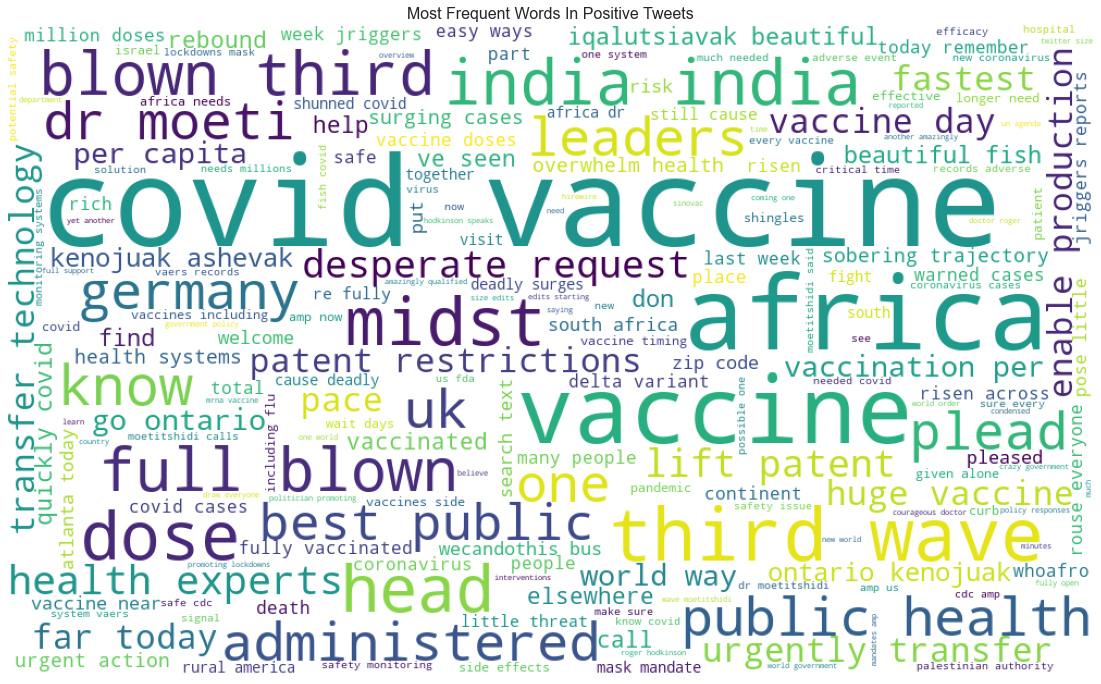

In [62]:
plt.figure(figsize=(20, 12))

plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(positive_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Positive Tweets', fontsize=16)
plt.show()


### words cloud for negative tweets

In [63]:
negative_tweets = tweets[tweets['score'] == 'negative']

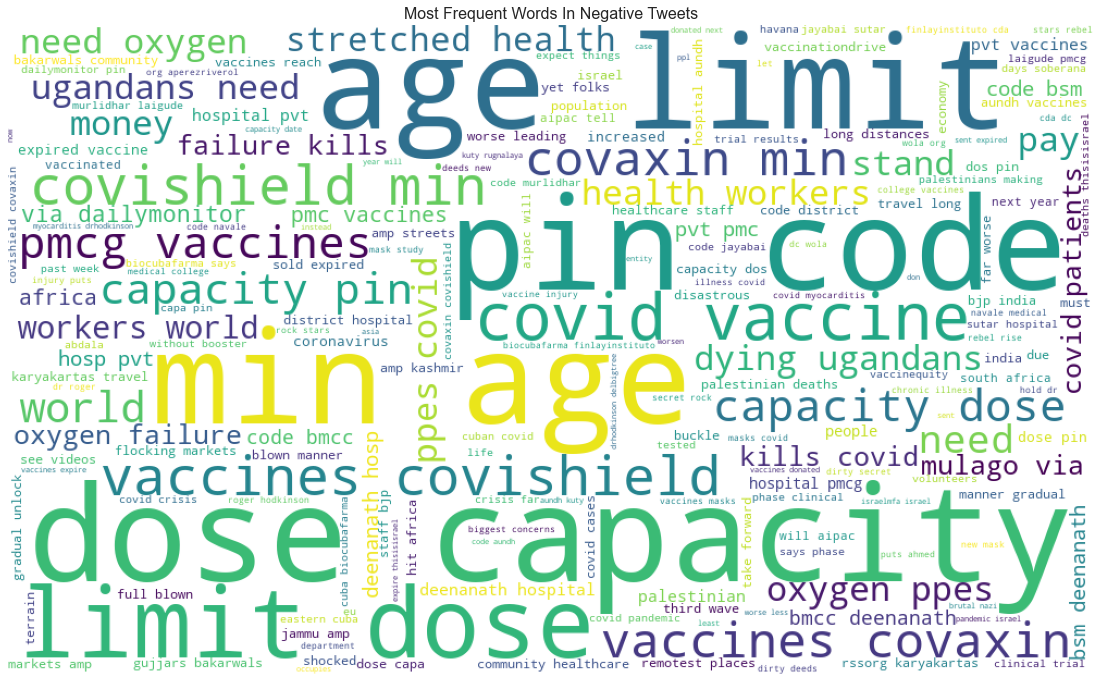

In [64]:
plt.figure(figsize=(20, 12))
plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(negative_tweets.clean_text.values)))
plt.axis('off')
plt.title('Most Frequent Words In Negative Tweets', fontsize=16)
plt.show()


### words cloud for neutral tweets

In [65]:
neutral_tweets = tweets[tweets['score'] == 'neutral']

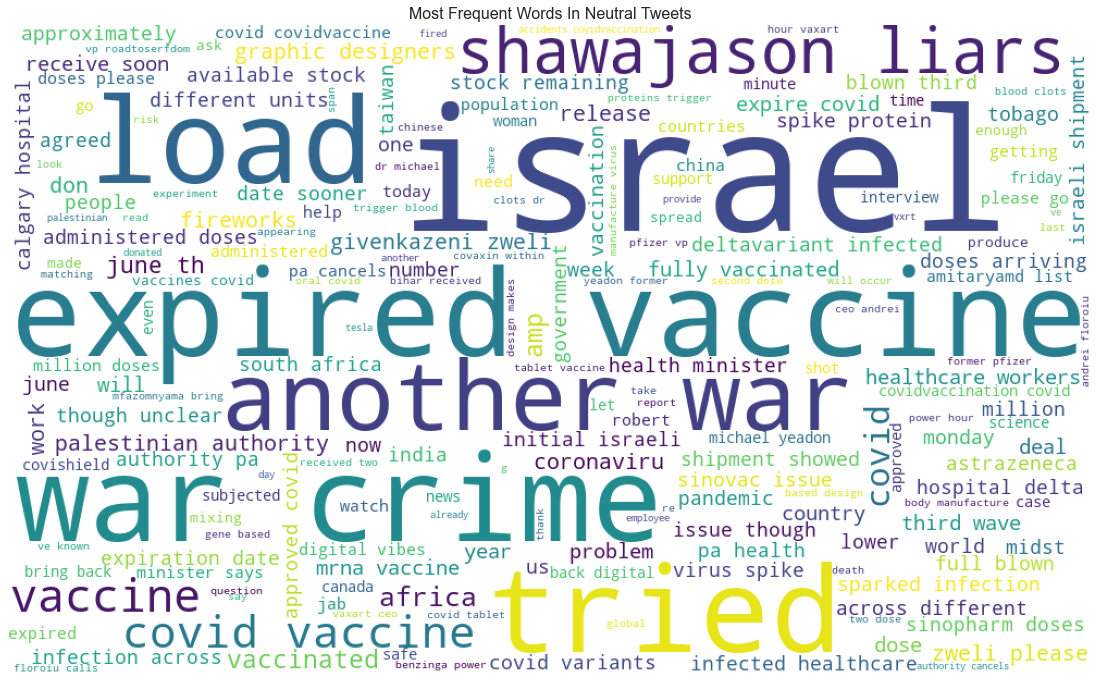

In [66]:
plt.figure(figsize=(20, 12))
plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(neutral_tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Neutral Tweets', fontsize=16)
plt.show()


### Word Cloud for all tweets

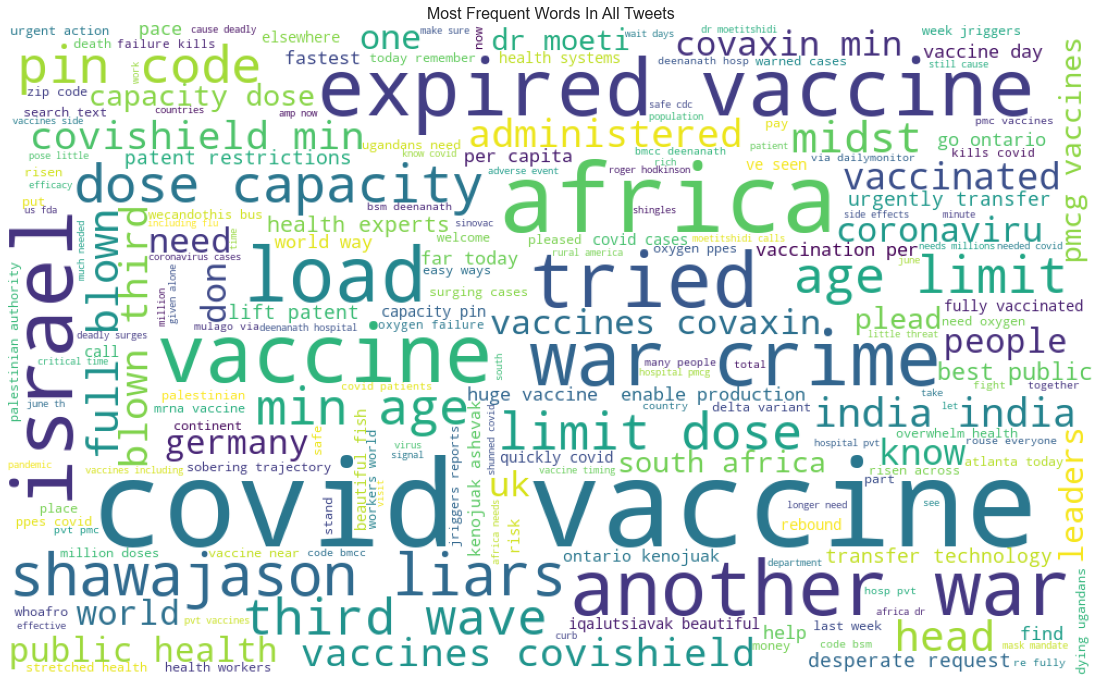

In [67]:
plt.figure(figsize=(20, 12))
plt.imshow(WordCloud(width=1000, height=600, background_color='white', stopwords=STOP_WORDS).generate(
    ' '.join(tweets.clean_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In All Tweets', fontsize=16)
plt.show()
